# Goal

Re-do alignment and gene expression quantification on published RNA-seq data from Kyle Loh's hESC --> mesoderm differentiation paper. This will allow us to compare the changes in RP <b>mRNA</b> levels during mesoderm differentiation to the changes in RP <b>protein</b> levels (the latter data comes from Naomi's work).

We think this is worth re-doing b/c 
<ol>
    <li> we don't have the detailed methods for how the spreadsheet that Naomi has was generated</li>
    <li> we do know how the published gene expression data was generated, but the pipeline mostly uses default STAR and RSEM parameters, which are likely not optimal for handling genes w/ many pseudogenes


# TODO
<ol>
    <li> Download at least 1 hESC dataset to use for piloting pipeline, using sra-toolkit </li>
    <li> Find and download other relevant datasets (replicates for each stage of differentiation) -- limit to first 10M reads to speed up computation </li>
    <li> Re-read and take notes on Kyle's paper on how they did their RNA-seq analysis. Did this a while ago (notes in Benchling) but need a refresher </li>
    <li> Try to replicate the pipeline described in the Sci Data 2016 paper (but only on the first 10M reads) -- make sure I'm roughly dealing with the same data and am getting the pipeline right (albeit only 10M reads per sample) </li>
    <li>Start experimenting with ways to include/exclude pseudogenes from alignment</li>
    


# links & references

main paper describing mesoderm differentiation, Cell 2016:
https://www-sciencedirect-com.stanford.idm.oclc.org/science/article/pii/S0092867416307401

main paper describing endoderm differentiation, Cell Stem Cell 2014:
https://www-cell-com.stanford.idm.oclc.org/cell-stem-cell/fulltext/S1934-5909(13)00556-0

paper specifically describing the mesoderm data, Scientific Data 2016:
https://www-nature-com.stanford.idm.oclc.org/articles/sdata2016109

All GEO entries associated w/ the Cell 2016 mesoderm paper SRP073808:
https://www.ncbi.nlm.nih.gov//sra/?holding=F1000&otool=stanford&term=SRP073808

All 5 runs of h7 hESC bulk RNA-seq (to use for piloting pipelines):
https://www.ncbi.nlm.nih.gov/sra/SRX1725562[accn]

Previous notes on Benchling: 
https://benchling.com/s/etr-xvYly9LylZJSn2Vay4eh

Previous notes on Google Doc:
https://docs.google.com/document/d/1HzouixEdGyJMMzsg9SNA2v_kKXIRD68kfcbyexAajAg/edit#


# NRG's gene expression spreadsheet vs. published

How was the gene expression data that Naomi emailed me actually obtained "Copy of Eleven way mesoderm RNA-seq table (Jan 29 2015)_orig"?
- name of tab in spreadsheet indicates it's in FPKM, whereas the paper methods use units of log(TPM+1) and I think the processed data they published is in TPM as well? 
- she said once that they aligned to a reference transcriptome, but paper methods say they used ENCODE long read pipeline and hg38. ENCODE pipeline uses STAR, which AFAIK only accepts reference genomes, not transcriptomes. 
- several RP pseudogenes are included as genes; their expression level is generally very low (< 100 in whatever units these are) compared to canonical RPs (in the 1000s)
        

# Downloading raw data

Found this script in a directory for an old project:

```bash
#!/bin/bash -l
#
#SBATCH -J fastq-dump
#SBATCH -o fastq-dump.o
#SBATCH -e fastq-dump.e
#
#SBATCH --mail-user adelexu@stanford.edu
#SBATCH --mail-type=ALL
#
#SBATCH -t 96:0:0
#SBATCH -A mbarna
#SBATCH --mem=8G
#
# options for partition are batch, interactive, or nih_s10
#SBATCH -p batch

#to run: sbatch sbatch.fastq-dump.10M.sh /path/to/destination/directory SRR0000000

module load sratoolkit/2.9.0

fastq-dump -I -X 10000000 --split-files -O $1 $2
```

I think I can use this safely; previously I had issues where SRA was saving huge .sra files for each fastq-dump to /home/adelexu, which has a very limited quota. Sysadmin told me to set up a symlink to trick SRA into saving into a directory on /labs/mbarna/users/adelexu, which is still there. Command for doing so was `mv $HOME/ncbi /labs/mbarna/users/adelexu/ && ln -s /labs/mbarna/users/adelexu/ncbi $HOME/ncbi`

The `--gzip` option allows me to dump directly as .gz file, which is useful. 

Will try calling this on just one SRR for one of the h7 hESC samples, and then come up w/ a Python wrapper to submit one of these jobs for each sample I want.

Figured out I can run an entire shell script from python (as multi-line argument to subprocess.check_output). 

Wrote fastq-dump.py (developed in dev_fastq-dump.py), ran for all SRRs listed in /labs/mbarna/users/adelexu/rptranscriptomics/SRP073808_bulk_RNA-seq_SRR.txt. Stored fastq.gz files, config, error, and log files in /labs/mbarna/users/adelexu/rptranscriptomics/fastq. note: only fastq-dumped first 10M reads (after skipping first 10K based on concern from https://edwards.sdsu.edu/research/fastq-dump/ that the first few reads are not representative 

# Task 1: replicate (approximately, on downsampled dataset) published results & compare to Naomi's spreadsheet

## Set up pilot

Made an extra copy of /labs/mbarna/users/adelexu/rptranscriptomics/fastq/hESC_1 directory to pilot_hESC_1 to use as a pilot dataset, truncated each of the fastq.gz files to first 1M reads to reduce runtime during dev

In [1]:
# setup for pilot

import os
import subprocess
os.chdir('/labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/')

In [1]:
# truncate to first 1M reads (=4M lines) out of the 10M downloaded
# recall that I skipped the first 10K when downloading the 10M

subprocess.check_output("zcat SRR3439477_1.fastq.gz | head -4000000 | gzip > SRR3439477_1_1M.fastq.gz", shell=True)
subprocess.check_output("zcat SRR3439477_2.fastq.gz | head -4000000 | gzip > SRR3439477_2_1M.fastq.gz", shell=True)

b''

In [3]:
# run fastqc

subprocess.check_output("sbatch \
--job-name=fastqc_pilot_hESC_1 \
--error=%x-%j.e \
--output=%x-%j.o \
--account=mbarna \
--partition=batch \
--time=0:30:0 \
--mem=1G <<EOF \n\
#!/bin/sh \n\
module load fastqc \n\
fastqc /labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/SRR3439477_1_1M.fastq.gz \n\
fastqc /labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/SRR3439477_2_1M.fastq.gz \n\
EOF", shell=True)

b'Submitted batch job 13464457\n'

b'Submitted batch job 13464457\n'

## Fastqc

fastqc results stored in /labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/

results look reasonable; read length is 21-150...wondering if this means that adapters have already been trimmed? In the Sci Data paper the Skewer parameters given include filtering out reads of length <21

I'll run Skewer again on these samples just to check if anything changes.

notes on skewer parameters, from manual downloaded from https://sourceforge.net/projects/skewer/files/, last updated 2015-05-12	:
* default -x and -y adapters sequences match the beginning of what the Sci Data paper used, but the Sci Data adapter sequences are longer
* Sci Data paper doesn't provide a -m option (mode of trimming) and no default is specified in manual, so I'm not sure what mdoe they're using (presumably paired-end?)
* default error rate per base is 0.1 for substitutions, 0.03 for indels. unclear what minimum overlap for adapter detection is for paired-end mode?
* -q option specifies to trim 3' end until specified quality is reached; I think this explains why there might still be some reads w/ <21 average Phred quality -- there may be bases on the 5' end w/ poor quality that survived the 3' trimming
* -n filters out reads w/ lots of Ns
* -u filters out undetermined mate-pair reads

In [7]:
# run Skewer
# parameters copied from Sci Data paper (for bulk RNA-seq) except added --compress option and ran on 1 core instead of 16

# can't figure out how to get skewer to put trimmed fastq files in any directory other than the default
# just moving files in a separate step instead

os.makedirs("/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer/pilot_hESC_1/", exist_ok=True)

subprocess.check_output("sbatch \
--chdir=/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer/pilot_hESC_1/ \
--job-name=skewer_pilot_hESC_1 \
--error=%x-%j.e \
--output=%x-%j.o \
--account=mbarna \
--partition=batch \
--time=1:0:0 \
--mem=1G <<EOF \n\
#!/bin/sh \n\
/labs/mbarna/users/adelexu/bin/skewer-0.1.127-linux-x86_64 \
-x AGATCGGAAGAGCACACGTCTGAACTCCAGTCACNNNNNNATCTCGTATGCCGTCTTCTGCTTG \
-y AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTAGATCTCGGTGGTCGCCGTATCATT \
-t 1 -q 21 -l 21 -n -u -f sanger --compress \
/labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/SRR3439477_1_1M.fastq.gz \
/labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/SRR3439477_2_1M.fastq.gz \n\
\
mv /labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/*trimmed*.fastq.gz \
/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer/pilot_hESC_1/ \n\
EOF", shell=True)

b'Submitted batch job 13465102\n'

b'Submitted batch job 13465102\n'


in parallel, going to run cutadapt on the raw fastq files b/c its default adapter trimming modes are better documented, so I will check if cutadapt finds any adapters to trim. note that its default min overlap is 3

In [8]:
# run cutadapt

dest_path="/labs/mbarna/users/adelexu/rptranscriptomics/post-cutadapt/pilot_hESC_1/"
os.makedirs(dest_path, exist_ok=True)

subprocess.check_output(f"sbatch \
--chdir={dest_path} \
--job-name=cutadapt_pilot_hESC_1 \
--error=%x-%j.e \
--output=%x-%j.o \
--account=mbarna \
--partition=batch \
--time=0:30:0 \
--mem=1G <<EOF \n\
#!/bin/sh \n\
module load cutadapt/2.4 \n\
cutadapt \
-a AGATCGGAAGAGCACACGTCTGAACTCCAGTCAC \
-A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTA \
-o {dest_path}SRR3439477_1_1M_post-cutadapt.fastq.gz \
-p {dest_path}SRR3439477_2_1M_post-cutadapt.fastq.gz \
/labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/SRR3439477_1_1M.fastq.gz \
/labs/mbarna/users/adelexu/rptranscriptomics/fastq/pilot_hESC_1/SRR3439477_2_1M.fastq.gz \n\
EOF", shell=True)

b'Submitted batch job 13465130\n'

b'Submitted batch job 13465130\n'

## Skewer results

Copied from log:

    Fri Jan 10 15:13:48 2020 >> done (170.717s)
    1000000 read pairs processed; of these:
          0 ( 0.00%) degenerative read pairs filtered out
          0 ( 0.00%) undetermined read pairs filtered out by contaminant control
          9 ( 0.00%) short read pairs filtered out after trimming by size control
          0 ( 0.00%) empty read pairs filtered out after trimming by size control
     999991 (100.00%) read pairs available; of these:
     112241 (11.22%) trimmed read pairs available after processing
     887750 (88.78%) untrimmed read pairs available after processing

Wondering whether the 11% that were trimmed are just reads that happened to end in >= 3 bases that matched the adapters...

Looks like for paired-end, there isn't a minimum overlap for adapter trimming -- just relies on info from the other mate pair? ... but in that case a false positive overlap shouldn't be possible  

Skewer doesn't seem to have correctly named the two output .fastq.gz files, but I checked and the first few reads in the read 1 and read 2 files are still correct:

SRR3439477_1_1M.fastq-trimmed-pair1.fastq.gz
SRR3439477_1_1M.fastq-trimmed-pair2.fastq.gz

Re-naming these to SRR3439477_1_1M.fastq-trimmed.fastq.gz and SRR3439477_2_1M.fastq-trimmed.fastq.gz to maintain consistency


## Cutadapt results

Copied from Cutadapt .o file:

    === Summary ===
    Total read pairs processed:          1,000,000
      Read 1 with adapter:                  27,358 (2.7%)
      Read 2 with adapter:                  24,731 (2.5%)
    Pairs written (passing filters):     1,000,000 (100.0%)
    Total basepairs processed:   292,830,973 bp
      Read 1:   146,463,244 bp
      Read 2:   146,367,729 bp
    Total written (filtered):    292,431,965 bp (99.9%)
      Read 1:   146,194,033 bp
      Read 2:   146,237,932 bp
    === First read: Adapter 1 ===
    Sequence: AGATCGGAAGAGCACACGTCTGAACTCCAGTCAC; Type: regular 3'; Length: 34; Trimmed: 27358 times.
    No. of allowed errors:
    0-9 bp: 0; 10-19 bp: 1; 20-29 bp: 2; 30-34 bp: 3
    Bases preceding removed adapters:
      A: 34.5%
      C: 25.1%
      G: 21.8%
      T: 16.8%
      none/other: 1.8%
    Overview of removed sequences
    length  count   expect  max.err error counts
    3       17948   15625.0 0       17948
    4       5249    3906.2  0       5249
    5       963     976.6   0       963
    6       107     244.1   0       107
    7       42      61.0    0       42
    8       30      15.3    0       30
    9       55      3.8     0       33 22
    ...
    145     4       0.0     3       0 1 1 2
    146     4       0.0     3       0 0 3 1
    147     3       0.0     3       0 1 0 2
    148     2       0.0     3       0 0 2
    149     5       0.0     3       0 2 0 3
    150     483     0.0     3       0 437 27 19
    
    ...
    ...
    ...
    
    === Second read: Adapter 2 ===

    Sequence: AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTA; Type: regular 3'; Length: 34; Trimmed: 24731 times.

    No. of allowed errors:
    0-9 bp: 0; 10-19 bp: 1; 20-29 bp: 2; 30-34 bp: 3

    Bases preceding removed adapters:
      A: 35.9%
      C: 23.7%
      G: 22.6%
      T: 17.7%
      none/other: 0.0%

    Overview of removed sequences
    length  count   expect  max.err error counts
    3       17075   15625.0 0       17075
    4       5076    3906.2  0       5076
    5       1053    976.6   0       1053
    6       120     244.1   0       120
    7       34      61.0    0       34
    8       33      15.3    0       33
    9       62      3.8     0       39 23
    10      83      1.0     1       33 50
    ...
    130     1       0.0     3       1
    132     1       0.0     3       0 0 0 1
    134     1       0.0     3       0 0 0 1
    135     3       0.0     3       0 1 1 1
    145     1       0.0     3       0 1
    147     1       0.0     3       0 0 1
    150     1       0.0     3       0 0 1
    
Seems to be quite a discrepancy between the Skewer and Cutadapt results... <3% of Read 1 and Read 2 were trimmed at all in Cutadapt, while 11% of read pairs were trimmed in Skewer. Note that if the downloaded reads had already been trimmed, the newly exposed "3'" end of some reads might now match the adapter sequence by chance. With either program, the degree of trimming is lower than I would expect if the downloaded data had been untrimmed, and higher than I would expect if it had already been trimmed.

Given that the loss of a few bases is not a major issue for RNA-seq data, I'll err on the side of assuming the downloaded fastq files were untrimmed and proceed with the post-skewer files.

## Prepare genomes for STAR and RSEM

Will adapt Python script from https://github.com/kundajelab/mesoderm/blob/master/RNA-seq/STAR_RSEM_prep.py, commit 1d3909b251d3841306f77d5fa9a3b86ba803ff7e. Need to download the requisite genome files first 

For the sake of comparison will first try to download the most similar reference genome to what Sci Data paper uses; can change to updated or alternatively curated reference genome later. Sci Data paper says they used hg38; in the STAR_RSEM_prep.py script on Pang Wei's Github, there are these two lines:

```
fastaGenome = "/srv/scratch/pangwei/mesoderm/bulk-rna/genome/hg20.GRCh38/GrCh38_ERCC92.genome.fa"

# all-inclusive gtf file
gtf = "/srv/scratch/pangwei/mesoderm/bulk-rna/genome/hg20.GRCh38/GENCODE_ann/gencode.v22/gencode.v22_ERCC92.annotation.gtf"
```

Not sure what the hg20 refers to (I think this is synonymous w/ hg38?) but GENCODE v22 makes sense -- it was released 3/2015 while the Cell 2016 paper was submitted 2/2015 and accepted 6/2016; so maybe they updated the code during revisions.

Also think I need to find an ERCC92 FASTA file and GTF to concatenate to the GENCODE files...

Also unsure whether they used primary assembly or full genome for sequences and annotations. Will try primary assembly first. Full genome (i.e. ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_22/GRCh38.p2.genome.fa.gz) contains patches and alternative haplotypes, which STAR manual says should not be included in the reference genome.

In [10]:
# download GENCODE v22 primary assembly .fa file

import os
import subprocess

dest_path = "/labs/mbarna/users/adelexu/rptranscriptomics/genomes/gencode.v22/"
job_name = "v22_fa_rsync"
job_time = "2:0:0"
job_mem = "1G"
shell_code = f"rsync -av rsync://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_22/GRCh38.primary_assembly.genome.fa.gz {dest_path}"

os.makedirs(dest_path, exist_ok=True)
sbatch_defaults = "--error=%x-%j.e --output=%x-%j.o --account=mbarna --partition=batch"

cmd_line=f"sbatch \
--chdir={dest_path} \
--job-name={job_name} \
{sbatch_defaults} \
--time={job_time} \
--mem={job_mem} <<EOF \n\
#!/bin/sh \n\
{shell_code}\n\
EOF"

subprocess.check_output(cmd_line, shell=True)


b'Submitted batch job 13470961\n'

b'Submitted batch job 13470961\n'

In [14]:
# download GENCODE v22 primary assembly .gtf file

dest_path = "/labs/mbarna/users/adelexu/rptranscriptomics/genomes/gencode.v22/"
job_name = "v22_gtf_rsync"
job_time = "0:5:0"
job_mem = "1G"
shell_code = f"rsync -av rsync://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_22/gencode.v22.primary_assembly.annotation.gtf.gz {dest_path}"

os.makedirs(dest_path, exist_ok=True)
sbatch_defaults = "--error=%x-%j.e --output=%x-%j.o --account=mbarna --partition=batch"

cmd_line=f"sbatch \
--chdir={dest_path} \
--job-name={job_name} \
{sbatch_defaults} \
--time={job_time} \
--mem={job_mem} <<EOF \n\
#!/bin/sh \n\
{shell_code}\n\
EOF"

subprocess.check_output(cmd_line, shell=True)


b'Submitted batch job 13470964\n'

b'Submitted batch job 13470964\n'

Downloaded ERCC .fa and .gtf from https://assets.thermofisher.com/TFS-Assets/LSG/manuals/ERCC92.zip, uploaded from local machine to /labs/mbarna/users/adelexu/rptranscriptomics/genomes/ERCC, and gzipped

In [17]:
# concatenate GENCODE and ERCC .fa and .gtf files
# note: turns out RSEM needs them in decompressed form, so should omit gzip step in the future

root_path = "/labs/mbarna/users/adelexu/rptranscriptomics/genomes/"

gencode_fa_path = os.path.join(root_path, "gencode.v22/GRCh38.primary_assembly.genome.fa.gz")
ercc_fa_path = os.path.join(root_path, "ERCC/ERCC92.fa.gz")

gencode_gtf_path = os.path.join(root_path, "gencode.v22/gencode.v22.primary_assembly.annotation.gtf.gz")
ercc_gtf_path = os.path.join(root_path, "ERCC/ERCC92.gtf.gz")

dest_path = os.path.join(root_path, "gencode.v22_ERCC")
fa_dest = os.path.join(dest_path, 'GRCh38.primary_assembly.genome_ERCC92.fa.gz')
gtf_dest = os.path.join(dest_path, 'gencode.v22.primary_assembly.annotation_ERCC92.gtf.gz')

job_name = "cat_gencode_ercc"
job_time = "0:30:0"
job_mem = "1G"
shell_code = f"zcat {gencode_fa_path} {ercc_fa_path} | gzip > {fa_dest} \n\
zcat {gencode_gtf_path} {ercc_gtf_path} | gzip > {gtf_dest}"

sbatch_defaults = "--error=%x-%j.e --output=%x-%j.o --account=mbarna --partition=batch"

cmd_line=f"sbatch \
--chdir={dest_path} \
--job-name={job_name} \
{sbatch_defaults} \
--time={job_time} \
--mem={job_mem} <<EOF \n\
#!/bin/sh \n\
{shell_code}\n\
EOF"

os.makedirs(dest_path, exist_ok=True)
subprocess.check_output(cmd_line, shell=True)

b'Submitted batch job 13470965\n'

b'Submitted batch job 13470965\n'

In [3]:
# prep for STAR and RSEM genome generation -- for RSEM, genome .fa and annotation .gtf files must be decompressed already

import os
import subprocess

root_path = "/labs/mbarna/users/adelexu/rptranscriptomics/genomes/gencode.v22_ERCC/"
fa_path = "GRCh38.primary_assembly.genome_ERCC92.fa.gz"
gtf_path = "gencode.v22.primary_assembly.annotation_ERCC92.gtf.gz"

job_name = "gunzip_gencode_ercc"
job_time = "0:30:0"
job_mem = "1G"
shell_code = f"gunzip {os.path.join(root_path, fa_path)}\n\
gunzip {os.path.join(root_path, gtf_path)}"

sbatch_defaults = "--error=%x-%j.e --output=%x-%j.o --account=mbarna --partition=batch"

cmd_line=f"sbatch \
--chdir={root_path} \
--job-name={job_name} \
{sbatch_defaults} \
--time={job_time} \
--mem={job_mem} <<EOF \n\
#!/bin/sh \n\
{shell_code}\n\
EOF"

subprocess.check_output(cmd_line, shell=True)

b'Submitted batch job 13475871\n'

b'Submitted batch job 13475871\n'

In [2]:
''' copied and modified STAR_RSEM_prep.py from 
https://github.com/kundajelab/mesoderm/blob/master/RNA-seq/STAR_RSEM_prep.py, 
commit 1d3909b251d3841306f77d5fa9a3b86ba803ff7e

changes:
- appropriate file paths
- Python 3 f-strings 
- submit each shell command as an sbatch job
- specify correct versions of STAR and RSEM when loading modules'''

# This file prepares genomes for STAR v2.4 and RSEM v1.2.21.
# TO USE: Replace paths.

# Modified from https://github.com/ENCODE-DCC/long-rna-seq-pipeline/blob/master/DAC/STAR_RSEM_prep.sh
# Commit 313830c7c10e8567091131c40bdec2b9477627e0

import os
import subprocess

root_path = "/labs/mbarna/users/adelexu/rptranscriptomics/genomes/gencode.v22_ERCC/"

# STAR genome directory
STARgenomeDir = os.path.join(root_path, "STAR_genome")
os.makedirs(STARgenomeDir, exist_ok=True)

# RSEM genome directory
RSEMgenomeDir = os.path.join(root_path, "RSEM_genome")
RSEMoutprefix = os.path.join(RSEMgenomeDir, "RSEM_genome")
os.makedirs(RSEMgenomeDir, exist_ok=True)

# fasta file(s)
fastaGenome = os.path.join(root_path, "GRCh38.primary_assembly.genome_ERCC92.fa")

# all-inclusive gtf file
gtf = os.path.join(root_path, "gencode.v22.primary_assembly.annotation_ERCC92.gtf")

sbatch_defaults = "--error=%x-%j.e --output=%x-%j.o --account=mbarna --partition=batch"

star_time="6:0:0" #ran for 6:0:0 w/ 32 G on 2 CPUs, took 1.5 h on 2 CPUs and about 32G
star_mem="32G"
star_cpus="2"

# generate STAR reference genome
STAR_cmd_line=f"sbatch \
--chdir={STARgenomeDir} \
--job-name=STAR_genome_gen \
{sbatch_defaults} \
--time={star_time} \
--mem={star_mem} \
--cpus-per-task={star_cpus} <<EOF \n\
#!/bin/sh \n\
module load STAR/2.4.1d \n\
STAR --runMode genomeGenerate \
--genomeDir {STARgenomeDir} \
--genomeFastaFiles {fastaGenome} \
--sjdbGTFfile {gtf} \
--sjdbOverhang 100 --outFileNamePrefix {STARgenomeDir} --runThreadN {star_cpus} \n\
EOF"

#print(subprocess.check_output(STAR_cmd_line, shell=True)) #only needed to re-run RSEM on most recent attempt

rsem_time="1:0:0" # previously ran for 6:0:0 w/ 32G on 2 CPUs, took ~2 min on 2 CPUs and about 1.5 G
rsem_mem="4G"
rsem_cpus="1"

# RSEM-prepare-reference 
RSEM_cmd_line=f"sbatch \
--chdir={RSEMgenomeDir} \
--job-name=RSEM_genome_gen \
{sbatch_defaults} \
--time={rsem_time} \
--mem={rsem_mem} \
--cpus-per-task={rsem_cpus} <<EOF \n\
#!/bin/sh \n\
module load rsem/1.2.21 \n\
rsem-prepare-reference --gtf {gtf} {fastaGenome} {RSEMoutprefix} \n\
EOF"

print(subprocess.check_output(RSEM_cmd_line, shell=True))

b'Submitted batch job 13485652\n'


Last STAR job: b'Submitted batch job 13477662\n'
Last RSEM job: not affected by the passage of time or changes in fashion

Initially ran this w/ STAR/2.4.0g1 but later found out that the generated genome was incompatible w/ twopassMode, so had to delete all STAR and RSEM output and re-run w/ STAR/2.4.1d

Didn't put RSEM files in right directory for some reason (instead of creating files in the RSEMgenomeDir it just uses that path as a suffix), but will manually move them -- fixed this in later run 

Outputs look reasonable for both STAR and RSEM.

# Process pilot_hESC_1 via STAR and RSEM

Again, modifying scripts from Pang Wei's Github. The README from run_STAR_RSEM.py says to run run_STAR_RSEM.py, which calls STAR_RSEM.sh. 

Looking at commit 1d3909b251d3841306f77d5fa9a3b86ba803ff7e for run_STAR_RSEM.py and STAR_RSEM.sh

copy/pasted STAR_RSEM.sh from the Github into STAR_RSEM_original.sh in the rptranscriptomics repo, made a copy (STAR_RSEM_modified.sh) and will edit -- will need to edit so it loads modules appropriately. Will not change any of the STAR alignment parameters or RSEM quantification parameters for now, but may edit the STAR reporting parameters to get more information on multi-aligning reads.

run_STAR_RSEM.py is mostly just input/output file management for STAR_RSEM.sh; will just handle that directly in this notebook for the pilot_hESC_1 dataset -- call sbatch on STAR_RSEM_modified.sh from this notebook

In [5]:
import os
import subprocess

sample_name = "pilot_hESC_1"
working_dir = os.path.join("/labs/mbarna/users/adelexu/rptranscriptomics/post-STAR-RSEM", sample_name)
os.makedirs(working_dir, exist_ok=True)

job_name = f"{sample_name}_SR"
job_time = "2:0:0"
job_mem = "32G"
job_cpus = "1"

script_path = "/home/adelexu/research/rptranscriptomics/rptranscriptomics/STAR_RSEM_modified.sh"
read1_path = "/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer/pilot_hESC_1/SRR3439477_1_1M.fastq-trimmed.fastq.gz"
read2_path = "/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer/pilot_hESC_1/SRR3439477_2_1M.fastq-trimmed.fastq.gz"
STARgenomeDir = "/labs/mbarna/users/adelexu/rptranscriptomics/genomes/gencode.v22_ERCC/STAR_genome"
RSEMoutprefix = "/labs/mbarna/users/adelexu/rptranscriptomics/genomes/gencode.v22_ERCC/RSEM_genome/RSEM_genome"
dataType = "str_PE"
nThreadsSTAR = job_cpus
nThreadsRSEM = job_cpus

sbatch_defaults = "--error=%x-%j.e --output=%x-%j.o --account=mbarna --partition=batch"

cmd_line=f"sbatch \
--chdir={working_dir} \
--job-name={job_name} \
{sbatch_defaults} \
--time={job_time} \
--mem={job_mem} \
--cpus-per-task={job_cpus} \
{script_path} {read1_path} {read2_path} {STARgenomeDir} {RSEMoutprefix} {dataType} {nThreadsSTAR} {nThreadsRSEM}"

print(subprocess.check_output(cmd_line, shell=True))

b'Submitted batch job 13488837\n'


b'Submitted batch job 13488837\n'

on first run, errored out b/c no such parameter as twopassMode in STAR/2.4.0g1, which I suspected b/c it wasn't in the manual. Evidently the STAR version must be a more recent one than reported in the paper -- instead of sticking with STAR/2.4.0g1, will just find the earliest STAR version that has this "--twopassmode basic" option..apparently that's STAR 2.4.1a 2015/04/17 according to release notes on Github...which may be what the authors meant in the first place. We actually don't have STAR/2.4.1a but we have STAR/2.4.1d; will use that instead -- fixed in STAR_RSEM_modified.sh. also, realized I should have been running this on the post-skewer fastq.gz files, not the fastq ones. fixed in above cell and re-ran.

on run 13488837, still got error in pilot_hESC_1_SR-13488837.e:
    mkdir: cannot create directory ‘Signal’: File exists
but run seems to have continued and there is a Log.out file in Signal that was generated by STAR w/ no apparent errors. 

All other log files seem error-free and Quant.genes.results was created

# Comparing to published analysis:

downloaded bulk_tpm.csv from http://mitra.stanford.edu/kundaje/pangwei/mesoderm_data/RNA-seq/bulk_tpm.csv, a link I found in https://github.com/kundajelab/mesoderm/blob/master/RNA-seq/bulkDataViz.Rmd commit #34a5a2fc70d49911954346f64755f720911cb2e3. I believe this spreadsheet was collated from the RSEM output (after filtering out samples w/o enough uniquely mapped reads) using getExpr.py, which is also in the git repo. 

After that, bulkDataViz.Rmd is used to further filter the data and correct for batch effects

this and a spreadsheet of sample metadata are stored in koh_sdata_2016

# Compare pilot_hESC_1_1M to hESC_1 from downloaded bulk_tpm.csv

In [48]:
pilot_file = "/labs/mbarna/users/adelexu/rptranscriptomics/post-STAR-RSEM/pilot_hESC_1/Quant.genes.results"
ref_file = "/labs/mbarna/users/adelexu/rptranscriptomics/koh_sdata_2016/bulk_tpm.csv"

import pandas as pd

pilot_df = pd.read_csv(pilot_file, sep='\t')
ref_df = pd.read_csv(ref_file, sep=',')
ref_df.rename(columns={'geneID':'gene_id'}, inplace=True)

print(pilot_df.shape)

pilot_df.head()

(60746, 7)


,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM
0,ENSG00000000003.13,"ENST00000373020.7,ENST00000494424.1,ENST000004...",2250.88,2020.44,31.0,68.41,51.81
1,ENSG00000000005.5,"ENST00000373031.4,ENST00000485971.1",940.50,710.06,0.0,0.00,0.00
2,ENSG00000000419.11,"ENST00000371582.7,ENST00000371584.7,ENST000003...",1074.69,844.24,9.0,47.53,36.00
3,ENSG00000000457.12,"ENST00000367770.4,ENST00000367771.9,ENST000003...",6364.00,6133.56,3.0,2.18,1.65
4,ENSG00000000460.15,"ENST00000286031.9,ENST00000359326.7,ENST000004...",3399.89,3169.45,6.0,8.44,6.39


In [49]:
print(ref_df.shape)
ref_df.head()

(60575, 35)


,geneSymbol,gene_id,APS_1,APS_2,APS_3,D2LtM_1,D2LtM_2,D3EarlySmt_1,D3EarlySmt_2,D3GARPpCrdcM_1,...,MPS_1,MPS_2,MPS_3,MPS_4,Sclrtm_1,Sclrtm_2,Smt_1,Smt_2,Smt_3,Smt_4
0,TSPAN6,ENSG00000000003.13,133.95,132.07,64.47,54.85,53.65,47.87,56.37,97.98,...,65.75,103.50,74.87,64.99,214.20,277.22,41.09,62.61,37.26,55.65
1,TNMD,ENSG00000000005.5,10.39,3.47,1.11,0.58,1.74,0.36,1.68,0.65,...,0.57,3.23,2.73,1.81,0.00,0.50,2.43,0.94,4.70,2.06
2,DPM1,ENSG00000000419.11,67.67,124.98,33.02,8.35,12.95,12.31,13.33,15.33,...,113.37,107.19,28.54,25.59,63.16,27.62,23.67,37.51,17.17,15.39
3,SCYL3,ENSG00000000457.12,2.59,1.40,2.61,5.03,4.70,2.98,3.71,5.52,...,3.04,2.59,3.98,3.57,3.76,5.54,3.16,4.65,3.89,4.03
4,C1orf112,ENSG00000000460.15,12.32,46.18,16.49,19.54,19.20,11.72,8.55,20.49,...,72.31,49.41,19.58,23.39,15.31,20.78,11.08,20.82,22.14,10.53


In [50]:
gene_id_not_in_pilot = ref_df.gene_id[~(ref_df.gene_id.isin(pilot_df.gene_id))] #none
gene_id_not_in_ref = pilot_df.loc[~(pilot_df.gene_id.isin(ref_df.gene_id))] #171 entries

gene_id_not_in_ref.TPM.describe() #seem to be mostly undetected genes...

count    171.000000
mean       3.170526
std       19.697488
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      129.810000
Name: TPM, dtype: float64

In [54]:
comb_df = ref_df[['gene_id', 'H7hESC_1']].merge(pilot_df[['gene_id','TPM']], how='inner', on='gene_id')
comb_df.columns = ['gene_id', 'ref', 'pilot']
print(comb_df.shape)
comb_df.head()

(60575, 3)


,gene_id,ref,pilot
0,ENSG00000000003.13,77.13,68.41
1,ENSG00000000005.5,0.73,0.00
2,ENSG00000000419.11,71.86,47.53
3,ENSG00000000457.12,2.60,2.18
4,ENSG00000000460.15,32.00,8.44


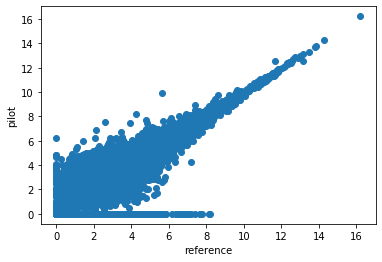

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.log2(comb_df.ref.add(1)), np.log2(comb_df.pilot.add(1)))
plt.xlabel('reference')
plt.ylabel('pilot')
plt.show()


Well...at least there's a correlation. Quite surprised that even at 2^8 = 256 TPM in the reference, there are quite a few genes that go entirely undetected in the 1M read pilot. I'm going to run the 10M read to see how much of an improvement that is...

# Run Skewer again on prev. skewered sample

This should tell me whether that 11% trimmed is typical for a sample that's already been trimmed.

In [63]:
# run Skewer again
# parameters copied from Sci Data paper (for bulk RNA-seq) except added --compress option and ran on 1 core instead of 16

import os
import subprocess

os.makedirs("/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer2/pilot_hESC_1/", exist_ok=True)

subprocess.check_output("sbatch \
--chdir=/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer2/pilot_hESC_1/ \
--job-name=skewer2_pilot_hESC_1 \
--error=%x-%j.e \
--output=%x-%j.o \
--account=mbarna \
--partition=batch \
--time=1:0:0 \
--mem=1G <<EOF \n\
#!/bin/sh \n\
/labs/mbarna/users/adelexu/bin/skewer-0.1.127-linux-x86_64 \
-x AGATCGGAAGAGCACACGTCTGAACTCCAGTCACNNNNNNATCTCGTATGCCGTCTTCTGCTTG \
-y AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTAGATCTCGGTGGTCGCCGTATCATT \
-t 1 -q 21 -l 21 -n -u -f sanger -z -o /labs/mbarna/users/adelexu/rptranscriptomics/post-skewer2/pilot_hESC_1/SRR3439477_trimmed \
/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer/pilot_hESC_1/SRR3439477_1_1M.fastq-trimmed.fastq.gz \
/labs/mbarna/users/adelexu/rptranscriptomics/post-skewer/pilot_hESC_1/SRR3439477_2_1M.fastq-trimmed.fastq.gz \n\
\
EOF", shell=True)

b'Submitted batch job 13512694\n'

This time the log file reads:

    Tue Jan 14 23:42:38 2020 >> done (166.685s)
    999991 read pairs processed; of these:
         0 ( 0.00%) degenerative read pairs filtered out
         0 ( 0.00%) undetermined read pairs filtered out by contaminant control
         0 ( 0.00%) short read pairs filtered out after trimming by size control
         0 ( 0.00%) empty read pairs filtered out after trimming by size control
    999991 (100.00%) read pairs available; of these:
       956 ( 0.10%) trimmed read pairs available after processing
    999035 (99.90%) untrimmed read pairs available after processing

So I guess the first trim was real...guess I'll be doing it for all the 10M read samples then.

# dev run_skewer.py

In [18]:
import os
import subprocess
import argparse
import glob
import json

parser = argparse.ArgumentParser(description="Run Skewer on all .fastq.gz files found in subdirectories of directory provided.")
parser.add_argument('--fastq_dir')
parser.add_argument('--out_dir')
parser.add_argument('--log_dir')
parser.add_argument("--sb_name")
parser.add_argument("--sb_time", default = "1:0:0")
parser.add_argument("--sb_mem", default = "1G")
parser.add_argument("--sb_cpus", default = "1")
parser.add_argument("--exclude", nargs=argparse.REMAINDER)
args = parser.parse_args('--fastq_dir /labs/mbarna/users/adelexu/rptranscriptomics/fastq \
--out_dir /labs/mbarna/users/adelexu/rptranscriptomics/post-skewer \
--log_dir /labs/mbarna/users/adelexu/rptranscriptomics/logs \
--sb_name 10M_skewer \
--exclude pilot_hESC_1 foo bar'.split())

# make sure output and log directories exist
os.makedirs(args.out_dir, exist_ok=True)
os.makedirs(args.log_dir, exist_ok=True)

sample = next(os.walk(args.fastq_dir))[1]

print(sample)
print(len(sample))

#exclude the pilot
sample = [s for s in sample if s not in args.exclude]

print(sample)
print(len(sample))

skewer_path = "/labs/mbarna/users/adelexu/bin/skewer-0.1.127-linux-x86_64"
adapter1 = "AGATCGGAAGAGCACACGTCTGAACTCCAGTCACNNNNNNATCTCGTATGCCGTCTTCTGCTTG"
adapter2 = "AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTAGATCTCGGTGGTCGCCGTATCATT"

sb_defaults = "-e %x-%j.e -o %x-%j.o -A mbarna -p batch"

# for each sample, make output subdirectory and call skewer
for smp in sample:
    os.makedirs(os.path.join(args.out_dir, smp), exist_ok=True)
    pair1 = glob.glob(os.path.join(args.fastq_dir, smp, "*_1.fastq.gz"))[0]
    pair2 = glob.glob(os.path.join(args.fastq_dir, smp, "*_2.fastq.gz"))[0]
    prefix = os.path.basename(pair1).replace("_1.fastq.gz", "")
    
    sh_code = "\n".join([f"#!/bin/sh",
                         f"{skewer_path} -x {adapter1} -y {adapter2} -t {args.sb_cpus} -q 21 -l 21 -n -u -f sanger -z -o {os.path.join(args.out_dir, smp, prefix)} {pair1} {pair2}"])
    
    sb_cmd = f"sbatch {sb_defaults} -D {args.log_dir} -J {smp}_{args.sb_name} -t {args.sb_time} --mem={args.sb_mem} -c {args.sb_cpus} <<EOF \n{sh_code}\nEOF"

    sb_sub_msg = subprocess.check_output(sb_cmd, shell=True).decode('ascii')
    print(sb_sub_msg)
    job_id = sb_sub_msg.strip().replace("Submitted batch job ", "")
 
#    uncomment if running from command line
#    with open(os.path.join(args.log_dir, f"{smp}_{args.sb_name}_skewer_{job_id}.config"), 'w') as config_file:
#    git_version = str(subprocess.check_output(['git', 'rev-parse', 'HEAD']).strip())
#    configs = {"git version": git_version, "arguments": vars(args), "sbatch command line": sb_cmd}
#    json.dump(configs, config_file, indent=4)
    
    
    

['Sclrtm_3', 'MPS_4', 'APS_2', 'foo', 'APS_1', 'MPS_3', 'Drmmtm_1', 'Sclrtm_2', 'CM_2', 'Smt_1', 'hESC_3', 'LtM_1', 'nonPXM_2', 'MPS_1', 'MPS_2', 'Drmmtm_4', 'Smt_2', 'hESC_2', 'Smt_3', 'bar', 'Smt_5', 'Smt_4', 'hESC_1', 'LtM_2', 'APS_3', 'PXM_1', 'pilot_hESC_1', 'nonPXM_1', 'PXM_2', 'Smt_6', 'PXM_3', 'Drmmtm_2', 'hESC_4', 'Sclrtm_1', 'Drmmtm_3', 'CM_1']
36
['Sclrtm_3', 'MPS_4', 'APS_2', 'APS_1', 'MPS_3', 'Drmmtm_1', 'Sclrtm_2', 'CM_2', 'Smt_1', 'hESC_3', 'LtM_1', 'nonPXM_2', 'MPS_1', 'MPS_2', 'Drmmtm_4', 'Smt_2', 'hESC_2', 'Smt_3', 'Smt_5', 'Smt_4', 'hESC_1', 'LtM_2', 'APS_3', 'PXM_1', 'nonPXM_1', 'PXM_2', 'Smt_6', 'PXM_3', 'Drmmtm_2', 'hESC_4', 'Sclrtm_1', 'Drmmtm_3', 'CM_1']
33


note: when I executed the above, it failed on pilot_hESC_1 b/c there was no appropriately named sample, so I added the option to exclude samples

In [10]:
prefix

'/labs/mbarna/users/adelexu/rptranscriptomics/fastq/PXM_1/SRR3439472'

# TODO
* examine RSEM output for pilot_hESC_1 -- figure out if these TPM values are comparable or at least correlate w/ the hESC_1 column in the provided bulk_tpm, which will tell me if my whole pipeline is roughly accurate (note, this is a difference of 1M reads vs. ~40X that, so there may be some noise in low-expressed genes) -- figure out which genes overlap in the pilot_hESC_1 vs downloaded bulk_tpm.csv output, and make scatterplot 
* if pilot_hESC_1 looks OK, make scripts to run Skewer and STAR-RSEM on all the samples (10M reads each). Run once w/ all the same parameters as published, then start running w/ varied parameters
* adapt getExpr.py to collect TPM values from the RSEM output for each sample
* adapt bulkDataViz.Rmd to correct for batch effects

* plot Naomi's proteomics data vs the gene expression values in the spreadsheet she sent -- this should replicate the analysis she did (for each RP gene, plot the gene expression values vs proteomics values for each of the cell types and calculate pearson & spearman correlation--may need to take log values for one or both axes)

* plot the spreadsheet vs the published data to see how much they differ 

* if different, plot Naomi's proteomics data vs the published gene expression data

# Various models of how RP pseudogenes might influence detected RP mRNA expression:

Defining RP pseudogenes: can find all annotated RP pseudogenes by name or gene family, but could also find (and self-annotate) unannotated pseudogenes by searching for regions of genome w/ homology to exons of RPs

how many pseudogenes are there for each RP gene, and how similar are they?

<ol>
    <li>RP pseudogenes aren't expressed at all, hence we should attribute any RP-like transcripts to parent gene. could achieve this by masking pseudogenes during alignment. note that if this results in many reads being attributed to the parent gene despite a number of consistent mismatches, it'll suggest that those reads should have been attributed elsewhere in the genome instead</li>
    <li> 

* , and aligner is able to distinguish them -- this is unlikely; many pseudogenes are basically indistinguishable from the parent gene's nucleotide sequence